# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [2]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

In [6]:
train.shape

(51916, 17)

In [5]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [9]:
train = train.dropna(axis=0)
train.isna().sum()

In [11]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
5,1725221,LAKEVIEW REHABILITATION AND NURSING CENTER,LAKEVIEW REHABILITATION AND NURSING CENTER,2245580.0,Long Term Care,Risk 1 (High),735 W DIVERSEY PKWY,CHICAGO,IL,60614.0,2016-02-22T00:00:00,Canvass,31. CLEAN MULTI-USE UTENSILS AND SINGLE SERVIC...,41.932632,-87.647973,"{'longitude': '-87.64797278441709', 'latitude'...",0


In [25]:
import category_encoders as ce

train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)

encoder = ce.BinaryEncoder()
dataset = encoder.fit_transform(dataset)

train = dataset[:train_objs_num]
test = dataset[train_objs_num:]

In [26]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['Fail'])
y = train['Fail']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced', 
    min_samples_leaf=0.005, 
    n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [28]:
cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... , score=0.6778894341546449, total=   6.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ....................... , score=0.6781162510909571, total=   1.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] ....................... , score=0.6662065558688977, total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s remaining:    0.0s


[CV] ....................... , score=0.6929716858975846, total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.7s remaining:    0.0s


[CV] ....................... , score=0.6823362941793292, total=   1.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.8s finished


array([0.67788943, 0.67811625, 0.66620656, 0.69297169, 0.68233629])

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train, y_train)

eli5.show_weights(permuter, top=None, feature_names=X_train.columns.tolist())

Weight,Feature
0.0582 ± 0.0000,Inspection Type_5
0.0527 ± 0.0000,Inspection Type_4
0.0331 ± 0.0000,Inspection ID
0.0151 ± 0.0000,License #
0.0078 ± 0.0000,Zip
0.0077 ± 0.0000,Latitude
0.0075 ± 0.0000,Longitude
0.0059 ± 0.0000,Inspection Type_6
0.0030 ± 0.0000,DBA Name_9
0.0028 ± 0.0000,Risk_1


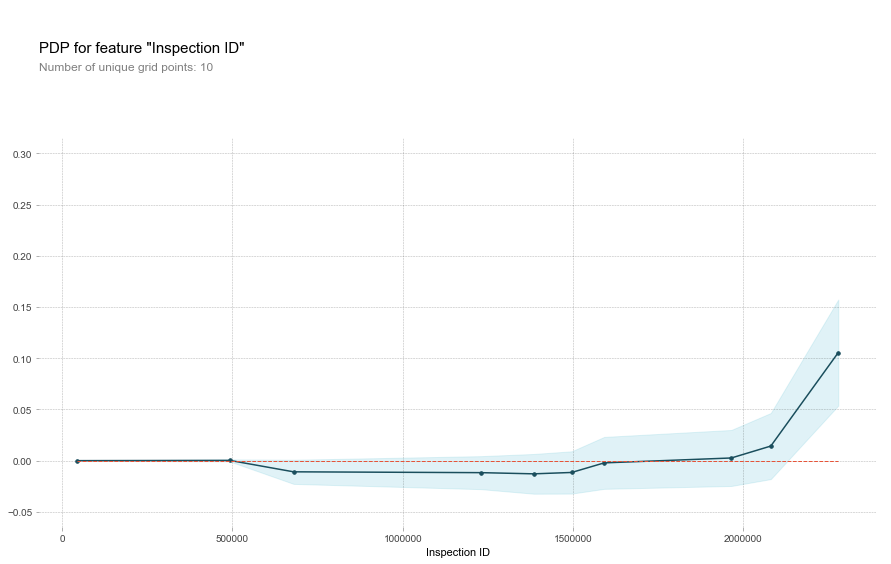

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Inspection ID'
pdp_isolated = pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_isolated,feature);